### Import Packages

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Read dataset

In [3]:
df=pd.read_csv("airline_passengers.csv")
df.head()

,Month,Thousands of Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


### EDA

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Month                    144 non-null    object
 1   Thousands of Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [5]:
df.describe()

,Thousands of Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [6]:
df["Month"]=pd.to_datetime(df["Month"])
df.set_index(['Month'],inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   Thousands of Passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


In [7]:
df.head()

,Thousands of Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [8]:
df.index.freq = 'MS'

In [9]:
df.isnull().sum()

Thousands of Passengers    0
dtype: int64

### Plot the data

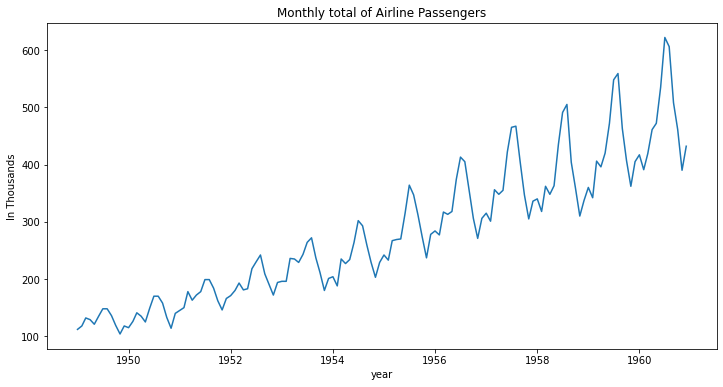

In [10]:
plt.figure(figsize=(12,6))
plt.plot(df['Thousands of Passengers'])
plt.title("Monthly total of Airline Passengers")
plt.ylabel("In Thousands")
plt.xlabel("year")
plt.show()

In [11]:
df.index[df.index.month==12]

DatetimeIndex(['1949-12-01', '1950-12-01', '1951-12-01', '1952-12-01',
               '1953-12-01', '1954-12-01', '1955-12-01', '1956-12-01',
               '1957-12-01', '1958-12-01', '1959-12-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', freq=None)

### Seasonality check

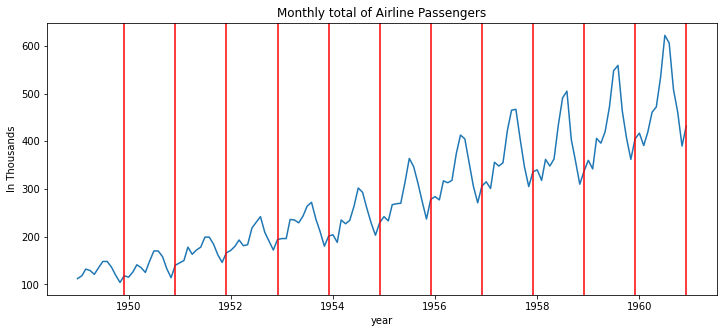

In [12]:
plt.figure(figsize=(12,5))
plt.plot(df['Thousands of Passengers'])
plt.title("Monthly total of Airline Passengers")
plt.ylabel("In Thousands")
plt.xlabel("year")
for x in df.index[df.index.month==12]:
    plt.axvline(x=x, color='red');
plt.show();

### Decompose the signal

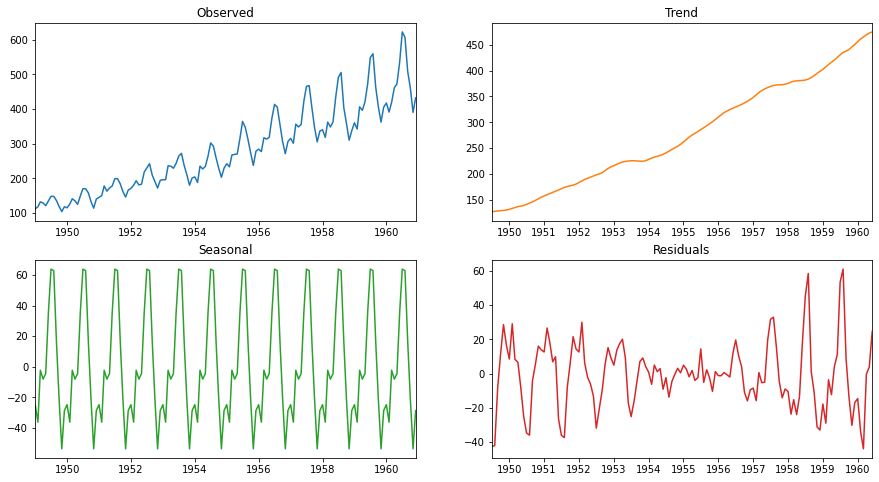

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df['Thousands of Passengers'], model='additive')
fig, axs = plt.subplots(2, 2,figsize=(15,8))
axs[0, 0].plot(result.observed)
axs[0, 0].autoscale(axis='x',tight=True)
axs[0, 0].set_title('Observed')
axs[0, 1].plot(result.trend,'tab:orange')
axs[0, 1].autoscale(axis='x',tight=True)
axs[0, 1].set_title('Trend')
axs[1, 0].plot(result.seasonal, 'tab:green')
axs[1, 0].autoscale(axis='x',tight=True)
axs[1, 0].set_title('Seasonal')
axs[1, 1].plot(result.resid, 'tab:red')
axs[1, 1].autoscale(axis='x',tight=True)
axs[1, 1].set_title('Residuals')
plt.show()

### Shift the data

In [14]:
df["Thousands of Passengers"].shift()

Month
1949-01-01      NaN
1949-02-01    112.0
1949-03-01    118.0
1949-04-01    132.0
1949-05-01    129.0
              ...  
1960-08-01    622.0
1960-09-01    606.0
1960-10-01    508.0
1960-11-01    461.0
1960-12-01    390.0
Freq: MS, Name: Thousands of Passengers, Length: 144, dtype: float64

In [15]:
df["Thousands of Passengers"].shift().shift()

Month
1949-01-01      NaN
1949-02-01      NaN
1949-03-01    112.0
1949-04-01    118.0
1949-05-01    132.0
              ...  
1960-08-01    535.0
1960-09-01    622.0
1960-10-01    606.0
1960-11-01    508.0
1960-12-01    461.0
Freq: MS, Name: Thousands of Passengers, Length: 144, dtype: float64

### Check for Stationarity

In [16]:
from statsmodels.tsa.stattools import adfuller
def adf_test(df):
    result=adfuller(df)
    print("P Value: ",result[1])
    if result[1]<=0.05:
        print("Strong evidence aganist Null Hypothesis. So, reject Null Hypothesis and conclude data is stationary.")
        return(True)
    else:
        print("Weak evidence aganist Null Hypothesis. So, accept Null Hypothesis and conclude data is non-stationary.")
        return(False)
adf_test(df)

P Value:  0.991880243437641
Weak evidence aganist Null Hypothesis. So, accept Null Hypothesis and conclude data is non-stationary.


False

### Automate conversion from non-stationary data to stationary data

In [17]:
def convert_non_stationary_to_stationary(df):
    d=0
    new_df=df
    while True:
        new_df=new_df-new_df.shift()
        new_df.dropna(inplace=True)
        d=d+1
        if adf_test(new_df):
            print("d-value is",d)
            break

In [18]:
convert_non_stationary_to_stationary(df)

P Value:  0.0542132902838255
Weak evidence aganist Null Hypothesis. So, accept Null Hypothesis and conclude data is non-stationary.
P Value:  2.7328918500142407e-29
Strong evidence aganist Null Hypothesis. So, reject Null Hypothesis and conclude data is stationary.
d-value is 2


### Split the data into train and test datasets

In [19]:
train = df.iloc[:len(df)-30]
test = df.iloc[len(df)-30:]

### Auto ARIMA Model

In [20]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from pmdarima import auto_arima
auto_arima(df['Thousands of Passengers'],seasonal=True,m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  144
Model:             SARIMAX(2, 1, 1)x(0, 1, [], 12)   Log Likelihood                -504.923
Date:                             Mon, 28 Mar 2022   AIC                           1017.847
Time:                                     10:19:59   BIC                           1029.348
Sample:                                          0   HQIC                          1022.520
                                             - 144                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5960      0.085      6.987      0.000       0.429       0.763
ar.L2          0.2143      0.091      2.343      0.019       0.035       0.394
ma.L1         -0.9819      0.038    -25.600      0.000      -1.057      -0.907
sigma2       129.3144     14.557      8.883      0.000     100.784     157.845
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 7.68
Prob(Q):                              0.98   Prob(JB):                         0.02
Heteroskedasticity (H):               2.33   Skew:                            -0.01
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Fit the model with train dataset

In [21]:
model = SARIMAX(train['Thousands of Passengers'],order=(2, 1, 1),seasonal_order=(0, 1, [], 12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:             Thousands of Passengers   No. Observations:                  114
Model:             SARIMAX(2, 1, 1)x(0, 1, [], 12)   Log Likelihood                -370.879
Date:                             Mon, 28 Mar 2022   AIC                            749.759
Time:                                     10:19:59   BIC                            760.219
Sample:                                 01-01-1949   HQIC                           753.993
                                      - 06-01-1958                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6015      0.807     -0.745      0.456      -2.183       0.980
ar.L2          0.0129      0.241      0.054      0.957      -0.460       0.486
ma.L1          0.4168      0.800      0.521      0.602      -1.151       1.985
sigma2        90.5207     13.275      6.819      0.000      64.502     116.539
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.42
Prob(Q):                              1.00   Prob(JB):                         0.30
Heteroskedasticity (H):               0.96   Skew:                             0.38
Prob(H) (two-sided):                  0.89   Kurtosis:                         2.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Predict the model with test dataset

In [22]:
start=len(train)
end=len(train)+len(test)-1
predicted_values = results.predict(start=start, end=end)

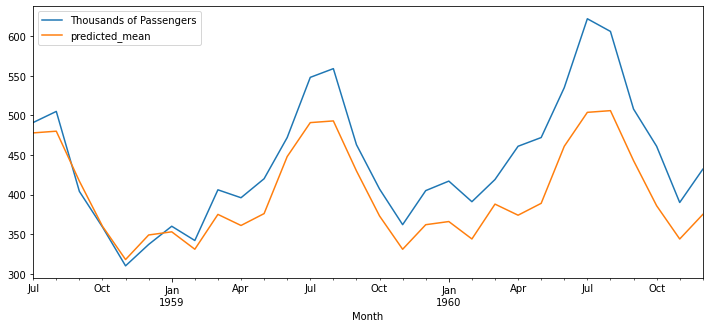

In [23]:
ax = test['Thousands of Passengers'].plot(figsize=(12,5))
predicted_values.plot()
plt.legend()
ax.autoscale(axis='x',tight=True)

### Evaluate the model

In [24]:
import sklearn as sk
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
print("mean_squared_error :",mean_squared_error(test['Thousands of Passengers'],predicted_values ))
print("root_mean_squared_error :",mean_squared_error(test['Thousands of Passengers'],predicted_values, squared=False))
print("mean_absolute_error :",mean_absolute_error(test['Thousands of Passengers'],predicted_values))
print("mean_absolute_percentage_error :",mean_absolute_percentage_error(test['Thousands of Passengers'],predicted_values))

mean_squared_error : 2790.7202146416457
root_mean_squared_error : 52.82726771887456
mean_absolute_error : 44.115291535735786
mean_absolute_percentage_error : 0.094358307935176


### Retrain the model with entire dataset

In [25]:
model = SARIMAX(df['Thousands of Passengers'],order=(2, 1, 1),seasonal_order=(0, 1, [], 12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:             Thousands of Passengers   No. Observations:                  144
Model:             SARIMAX(2, 1, 1)x(0, 1, [], 12)   Log Likelihood                -504.923
Date:                             Mon, 28 Mar 2022   AIC                           1017.847
Time:                                     10:20:00   BIC                           1029.348
Sample:                                 01-01-1949   HQIC                          1022.520
                                      - 12-01-1960                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5960      0.085      6.987      0.000       0.429       0.763
ar.L2          0.2143      0.091      2.343      0.019       0.035       0.394
ma.L1         -0.9819      0.038    -25.600      0.000      -1.057      -0.907
sigma2       129.3144     14.557      8.883      0.000     100.784     157.845
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 7.68
Prob(Q):                              0.98   Prob(JB):                         0.02
Heteroskedasticity (H):               2.33   Skew:                            -0.01
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Forecast the Future...😎

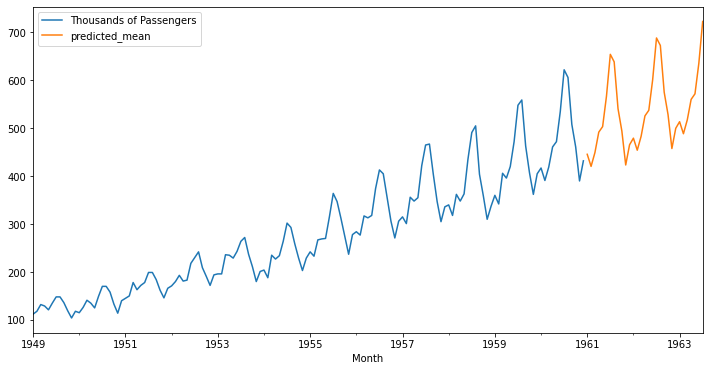

In [26]:
predicted_values = results.predict(start=len(df), end=len(df)+30)
df['Thousands of Passengers'].plot(figsize=(12,6))
predicted_values.plot()
plt.legend()
plt.show()